# Application of Logistic Regression To Titanic dataset

### by Yuan Huang

This project used the LogisticRegressionCV from sklearn.linear_model to classify the Titanic dataset downloaded from Kaggle. Intensive data exploration (seaborn pandas and matplotlib) was used to find the relationships between target variable (survived) and other features. Such a data exploaration provides useful information for the feature selection and data cleaning.  
Results shown that the precision and recall are both above 94%, and a high value of >0.97 for the under the curve area score of the ROC curve. 

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap 
from scipy import optimize 
%matplotlib inline

### Test case: titanic dataset
This part fit a optimized loagistic regression model using CV, and predict the survival of passagers on Titanic. The dataset was downloaded from Kaggle.com. First, load the dataset and do some simple data exploration.

In [7]:
ta_df=pd.read_csv("train.csv")

In [8]:
ta_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
ta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


We can see some columns contain missing values, which need to be either imputed or eliminated. In addition, there are some string type columns that need to be converted to numeric for modeling. Let's first define the target variable.

In [10]:
y_ta=ta_df['Survived']

#### Data Exploration

The purpose of the data exploration is to find the relationship between target and feature variables, and the distribution of the feature variables. First, we check the distribution/count of the target variable in male and female passagers.

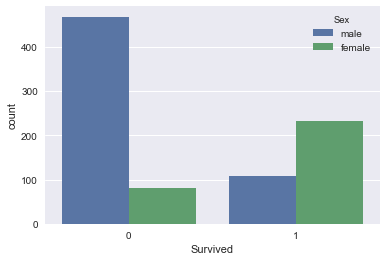

In [11]:
sns.countplot(x='Survived',hue='Sex',data=ta_df)

It is clear that in the survived and non-survived populations, the distributions of the male and female passagers are different. The different distributions of male and female passagers in survivor and non-survivor populations shows that sex is a useful feature that can help us to differentiate the survivor and non-survivor passagers, which should be included in the model.

Next, let's check Pclass column

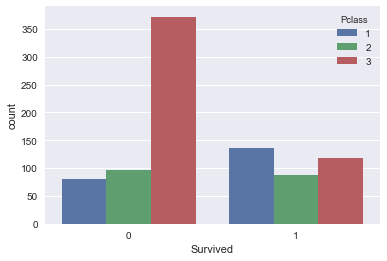

In [12]:
sns.countplot(x='Survived',hue='Pclass',data=ta_df)

We see that the distributions of different Pclass are tremendously different in survivor and non-survivor populations, and therefore, should be included in the model. Then how about the SibSp feature? 

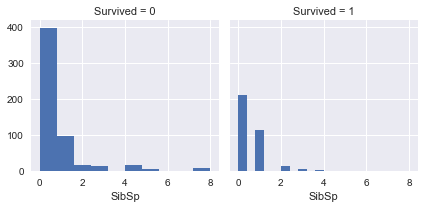

In [13]:
g=sns.FacetGrid(ta_df,col='Survived')
g.map(plt.hist,"SibSp")

From the above figure, it is obvious that SibSp has very different distributions in survivor and non-survivor populations.
Next, let's look at Age.

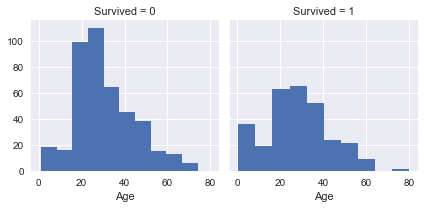

In [14]:
g=sns.FacetGrid(ta_df,col='Survived')
g.map(plt.hist,"Age")

The distribution in survivor and non-survivor populations have similar profile shapes. For example, the age range with the highest frequency occur in 20-40 for both populations. However, considering the proportion of the age population, there is still some apparent difference: for example, in the survivor population, the proportion of kids (age<10) is much higher than that in nonsurvivor population. Therefore, age can provide us with some useful information to differentiate the survival of a passager, and will be included in the model.

Next, let's look at other features, including Fare, Embarked and Parch

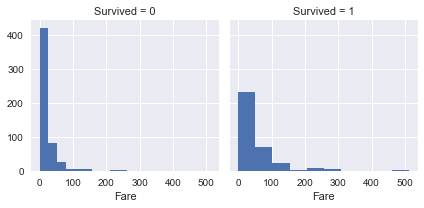

In [15]:
g=sns.FacetGrid(ta_df,col='Survived')
g.map(plt.hist,"Fare")

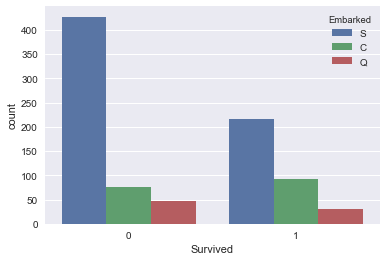

In [16]:
sns.countplot(x='Survived',hue='Embarked',data=ta_df)

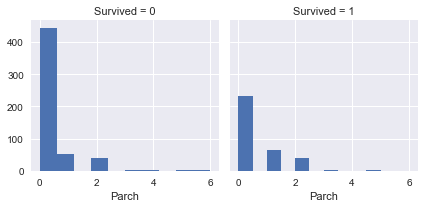

In [17]:
g=sns.FacetGrid(ta_df,col='Survived')
g.map(plt.hist,"Parch")

Theses features are similar in that in both survivor and non-survivor populations, the distributions of these feature have similar profile shapes. However, it is clear that the proportions of the sub-groups of these features in survivor and non-survivor populations are different. For example,for Fare, the proportion of the low fare passengers in non-survivor population is much higer than that in survivor population. The same trends can be observed for Parch and Embarked features. Therefore, these features will all provide useful information to differentiate the survivor from non-survivor passengers and will be included in the model.

#### Clean the data
Based on the data exploration, we have decided which columns should be included in the model. We then remove columns that we think will not provide useful information to differentiate the survivor and non-survivor passengers. Bascially, we follow the following rules:

1. remove columns where each observation has uniuqe values, such as PassengerID, Name and Ticket
2. remove columns having large portions of missing values, such as Cabin
3. remove columns that are highly correlated, and only keep one of columns representing the similar pattern. 

In [18]:
columns_selected=['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
ta_df=ta_df[columns_selected]

In [19]:
ta_df.shape

(891, 7)

In [20]:
ta_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


#### Data Imputation
After we select the features for modeling, we check if there is any missing data in feature columns. First, we use the infor() of pandas to check the distribution of missing values

In [21]:
ta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 48.8+ KB


We notice that both Age and Embarked columns have missing values. Embarked column only misses two values, so let's start from this feature, and check the counts of different values of this column. 

In [22]:
ta_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

We notice from the distribution of the Embarked data, 'S' is the most frequent value, and its frequency far exceeds the frequency of the other values. Therefore, we will use 'S' to fill the missing value for Embarked column.

In [23]:
ta_df.loc[:,'Embarked'].fillna('S',inplace=True)

C:\Anaconda2\lib\site-packages\pandas\core\generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [24]:
ta_df['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

Next, let's look at the 'Age' feature. We notice that the age is closely related to the Pclass, as shown in the following figure:

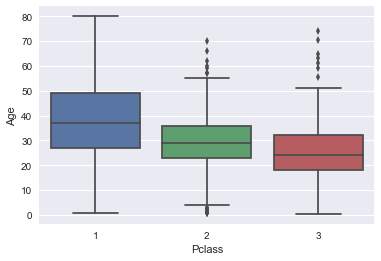

In [26]:
sns.boxplot(x='Pclass',y='Age',data=ta_df)

It is natrual to explore if there is any correlation between age and sex, in addition to Pclass. We check this by boxplot:

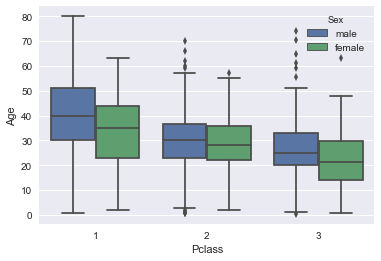

In [27]:
sns.boxplot(x='Pclass',y='Age',hue='Sex',data=ta_df)

Although we do see some correlation between sex and age, especially for Pclass 1 and 3, the difference in the average age for male and female passengers are small, so we will ignore it, and just use Pclass to do the imputation for 'Age' feature. We impute the missing age of a passenger by the average age of the Pclass the passenger belongs to.

In [46]:
ta_df.loc[(ta_df['Age'].isnull()) & (ta_df['Pclass']==1),'Age']=ta_df.loc[(ta_df['Age'].notnull()) & (ta_df['Pclass']==1),'Age'].mean()
ta_df.loc[(ta_df['Age'].isnull()) & (ta_df['Pclass']==2),'Age']=ta_df.loc[(ta_df['Age'].notnull()) & (ta_df['Pclass']==2),'Age'].mean()
ta_df.loc[(ta_df['Age'].isnull()) & (ta_df['Pclass']==3),'Age']=ta_df.loc[(ta_df['Age'].notnull()) & (ta_df['Pclass']==3),'Age'].mean()

In [47]:
ta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Pclass        891 non-null int64
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Sex_male      891 non-null uint8
Embarked_Q    891 non-null uint8
Embarked_S    891 non-null uint8
dtypes: float64(2), int64(3), uint8(3)
memory usage: 37.5 KB


Now, we see all the missing values are filled.

#### Data transformation for string features
We notice that values in 'Sex' and 'Embarked' columns are strings, which need to be converted to numeric values before modeling. We tranform these columns to numeric values by the get_dummies method of pandas.

In [48]:
ta_df=pd.get_dummies(data=ta_df,columns=['Sex','Embarked'],drop_first=True)

ValueError: labels ['Sex' 'Embarked'] not contained in axis

In [49]:
ta_df.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0
2,3,26.0,0,0,7.9250,0,0,1
3,1,35.0,1,0,53.1000,0,0,1
4,3,35.0,0,0,8.0500,1,0,1


Next, we make sure that there is no missing values in the dataset, and all the features we want are in the feature matrix by using the info() method of pandas.

In [50]:
ta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Pclass        891 non-null int64
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Sex_male      891 non-null uint8
Embarked_Q    891 non-null uint8
Embarked_S    891 non-null uint8
dtypes: float64(2), int64(3), uint8(3)
memory usage: 37.5 KB


#### Fit model
Here we use LogisticRegressionCV model from sklearn, and optimize the C value, which controls the regularization of the regression to overcome the overfitting.

In [51]:
from sklearn.linear_model import LogisticRegressionCV
lr=LogisticRegressionCV(Cs=[0.1,1,5,10,20],cv=5)
lr.fit(ta_df,y_ta)

LogisticRegressionCV(Cs=[0.1, 1, 5, 10, 20], class_weight=None, cv=5,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

Now, read the test dataset, process the dataset using the same procedures as in training dataset, and predict the 'Survived' value for test dataset by the fitted model.

In [52]:
ts_df=pd.read_csv("test.csv")

In [53]:
ts_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [54]:
columns_selected=['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
ts_df=ts_df[columns_selected]
ts_df['Embarked'].fillna('S',inplace=True)
ts_df=pd.get_dummies(data=ts_df,columns=['Sex','Embarked'],drop_first=True)
ts_df.loc[(ts_df['Age'].isnull()) & (ts_df['Pclass']==1),'Age']=ts_df.loc[(ts_df['Age'].notnull()) & (ts_df['Pclass']==1),'Age'].mean()
ts_df.loc[(ts_df['Age'].isnull()) & (ts_df['Pclass']==2),'Age']=ts_df.loc[(ta_df['Age'].notnull()) & (ts_df['Pclass']==2),'Age'].mean()
ts_df.loc[(ts_df['Age'].isnull()) & (ts_df['Pclass']==3),'Age']=ts_df.loc[(ta_df['Age'].notnull()) & (ts_df['Pclass']==3),'Age'].mean()

In [55]:
ts_df.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,1,1,0
1,3,47.0,1,0,7.0000,0,0,1
2,2,62.0,0,0,9.6875,1,1,0
3,3,27.0,0,0,8.6625,1,0,1
4,3,22.0,1,1,12.2875,0,0,1


In [56]:
ts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
Pclass        418 non-null int64
Age           418 non-null float64
SibSp         418 non-null int64
Parch         418 non-null int64
Fare          417 non-null float64
Sex_male      418 non-null uint8
Embarked_Q    418 non-null uint8
Embarked_S    418 non-null uint8
dtypes: float64(2), int64(3), uint8(3)
memory usage: 17.6 KB


Notced that Fare column has one missing value, we use the column mean to impute this missing value and then predict the target variable.

In [57]:
ts_df.loc[ts_df['Fare'].isnull(),'Fare']=ts_df.Fare.mean()

#### Model evaluation
The fitted model is evaluated by test dataset using confustion_matrix and classification_report tools from sklearn.

In [58]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

In [59]:
y_pred=lr.predict(ts_df)
y_pred_prob=lr.predict_proba(ts_df)[:,1]

In [60]:
y_test_df=pd.read_csv("gender_submission.csv")
y_test=y_test_df['Survived'].values

In [61]:
print "classification report",classification_report(y_test,y_pred),"\n"
print "confusion matrix",confusion_matrix(y_test,y_pred)

classification report              precision    recall  f1-score   support

          0       0.95      0.95      0.95       266
          1       0.91      0.92      0.92       152

avg / total       0.94      0.94      0.94       418


confusion matrix [[252  14]
 [ 12 140]]


The values of precision and recall are very good, both 0.94

In [62]:
fpr,tpr,_=roc_curve(y_test,y_pred_prob)

('ROC AUC score is: ', 0.97798773248911752)


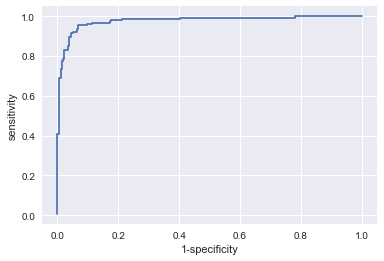

In [63]:
plt.plot(fpr,tpr)
plt.xlabel("1-specificity")
plt.ylabel("sensitivity")
print("ROC AUC score is: ",roc_auc_score(y_test,y_pred_prob))

The classifier has a high roc auc score ( > 0.97).